In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os
from importlib import reload

In [2]:
import dataset_utils
from glob import glob

In [3]:
reload(dataset_utils)

<module 'dataset_utils' from '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/dataset_utils.py'>

In [4]:
bg_noise_dir = '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/data/03_09_2024_katie_pc_bg_noise/all_samples_merged.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [5]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            num_points_removed +=1
            points_removed.append(point)
    return filtered_data

In [6]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        all_train_points=[]
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    all_train_points.append(bg_rm_arr)
                
                concatenated_train_points = np.concatenate(all_train_points, axis=0)
                # concatenated_train_points = background_subtraction(background_data, concatenated_train_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_train_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_train_points[sampled_indices].astype(np.float16)
                train_points.append(sampled_data)
                train_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
               
        all_test_points = []
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    all_test_points.append(bg_rm_arr)
                
                concatenated_test_points = np.concatenate(all_test_points, axis=0)
                # concatenated_test_points = background_subtraction(background_data, concatenated_test_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_test_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_test_points[sampled_indices].astype(np.float16)
                
                test_points.append(sampled_data)
                test_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
                # print(test_labels)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [7]:

# def parse_dataset(num_points, DATA_DIR):
#     train_points = []
#     train_labels = []
#     test_points = []
#     test_labels = []
#     class_map = {}
#     folders = glob(os.path.join(DATA_DIR, "[!README]*"))

#     for i, folder in enumerate(folders):
#         print("processing class: {}".format(os.path.basename(folder)))
#         # store folder name with ID so we can retrieve later
#         class_map[i] = folder.split("/")[-1]
#         # gather all files
#         train_files = glob(os.path.join(folder, "train/*"))
#         test_files = glob(os.path.join(folder, "test/*"))

#         all_train_points=[]
#         for f in train_files:
#             with open(f, 'rb') as file:
#                 data = pickle.load(file)
#                 all_train_points.append(data)
#                 concatenated_train_points = np.concatenate(all_train_points, axis=0)
#                 np.random.seed(42)
#                 sampled_indices = np.random.choice(concatenated_train_points.shape[0], size=num_points, replace=True)
#                 sampled_data = concatenated_train_points[sampled_indices].astype(np.float16)
                
#                 train_points.append(sampled_data)
#                 train_labels.append(i)
               
#         all_test_points = []
#         for f in test_files:
#             with open(f, 'rb') as file:
#                 data = pickle.load(file)
#                 all_test_points.append(data)
#                 concatenated_test_points = np.concatenate(all_test_points, axis=0)
#                 np.random.seed(42)
#                 sampled_indices = np.random.choice(concatenated_test_points.shape[0], size=num_points, replace=True)
#                 sampled_data = concatenated_test_points[sampled_indices].astype(np.float16)

#                 test_points.append(sampled_data)
#                 test_labels.append(i)
#     return (
#         np.array(train_points),
#         np.array(test_points),
#         np.array(train_labels),
#         np.array(test_labels),
#         class_map,
#     )

In [8]:
DATA_DIR = "data/3_09_2024_lab_pc_raw_data"
NUM_POINTS = 100
NUM_FRAMES = 3
NUM_CLASSES = 2
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: walking
processing class: jumping
train_points shape: (151, 100, 5)
test_points shape: (39, 100, 5)
train_labels shape: (151,)
test_labels shape: (39,)


In [9]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [10]:
train_size = 0.8
seed = 42
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points), seed=seed).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points), seed=seed).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [11]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer

In [12]:
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
import numpy as np

keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_features):
    inputs = keras.Input(shape=input_shape)

    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling1D
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Reshape((-1, 1024))(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (NUM_POINTS, 5)  # Adjust this based on your input data
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)

model = create_pointnet_model(input_shape, num_features)
model.summary()


Model: "pointnet_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 64)   │      2,112 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 512)  │     33,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 100, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_2[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 25)        │      3,225 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 5)      │          0 │ dense_2[0][0]   

 Total params: 3,112,411 (11.87 MB)

 Trainable params: 3,107,867 (11.86 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [14]:
INIT_TIMESTAMP = "9_09_2024_pointlstm_bg_rm_v2"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [16]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

In [17]:


model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback]  
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 8.1854 - sparse_categorical_accuracy: 0.4495
Epoch 1: val_loss improved from inf to 5.65815, saving model to model/checkpoints/9_09_2024_pointlstm_bg_rm_v2/best.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - loss: 8.0064 - sparse_categorical_accuracy: 0.4546 - val_loss: 5.6582 - val_sparse_categorical_accuracy: 0.7419
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 5.5354 - sparse_categorical_accuracy: 0.7922 
Epoch 2: val_loss improved from 5.65815 to 4.30722, saving model to model/checkpoints/9_09_2024_pointlstm_bg_rm_v2/best.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 5.4266 - sparse_categorical_accuracy: 0.7987 - val_loss: 4.3072 - val_sparse_categorical_accuracy: 0.9677
Epoch 3/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.5623 - sparse_categorical_accuracy: 0.9965
Epoch 3: val_loss improved from 4.30722 to 4.28831, saving model to model/checkpoints/9_09_2024_pointlstm_bg_rm_v2/best.weights.h

In [18]:
from matplotlib import pyplot as plt

2024-09-09 19:18:39.980881: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
[[[ 3.2959e-01 -1.2891e-01  2.9824e+00  0.0000e+00  1.2100e+02]
  [ 1.5840e+00 -3.9062e-02  1.1836e+00  0.0000e+00  1.3800e+02]
  [-1.3955e+00  9.8242e-01 -1.6797e-01  0.0000e+00  1.3900e+02]
  ...
  [-8.2227e-01  1.8379e+00  7.0312e-01 -5.0098e-01  1.9800e+02]
  [ 1.5840e+00 -3.9062e-02  1.1836e+00  0.0000e+00  1.3800e+02]
  [-6.1816e-01  1.6914e+00  1.5430e+00 -6.2598e-01  2.3500e+02]]

 [[ 2.4609e+00  5.3125e+00 -1.1562e+00 -7.5146e-01  1.7300e+02]
  [ 3.9771e-01  2.7402e+00  7.4414e-01  8.7646e-01  1.7200e+02]
  [ 2.1094e-01  2.7324e+00  1.2754e+00 -7.5146e-01  2.6600e+02]
  ...
  [-1.0010e-01  5.8125e+00 -3.2422e-01  8.7646e-01  2.2500e+02]
  [-8.8867e-01  2.1055e+00  3.2324e-01  0.0000e+00  1.2000e+02]
  [ 2.6484e+00  3.2285e+00  5.3027e-01  0.0000e+00  1.4600e+02]]

 [[ 2.4609e+00  5.3125e+00 -1.1562e+00 -7.5146e-01  1.7300e+02]
  [ 2.4570e+00  4.3555e+00 -8.6719e-01 -2.5049e-01  1.2700e+02]
  [-4.8047e+00  2.3828e+00  6.1133e-01  0.0000e+0

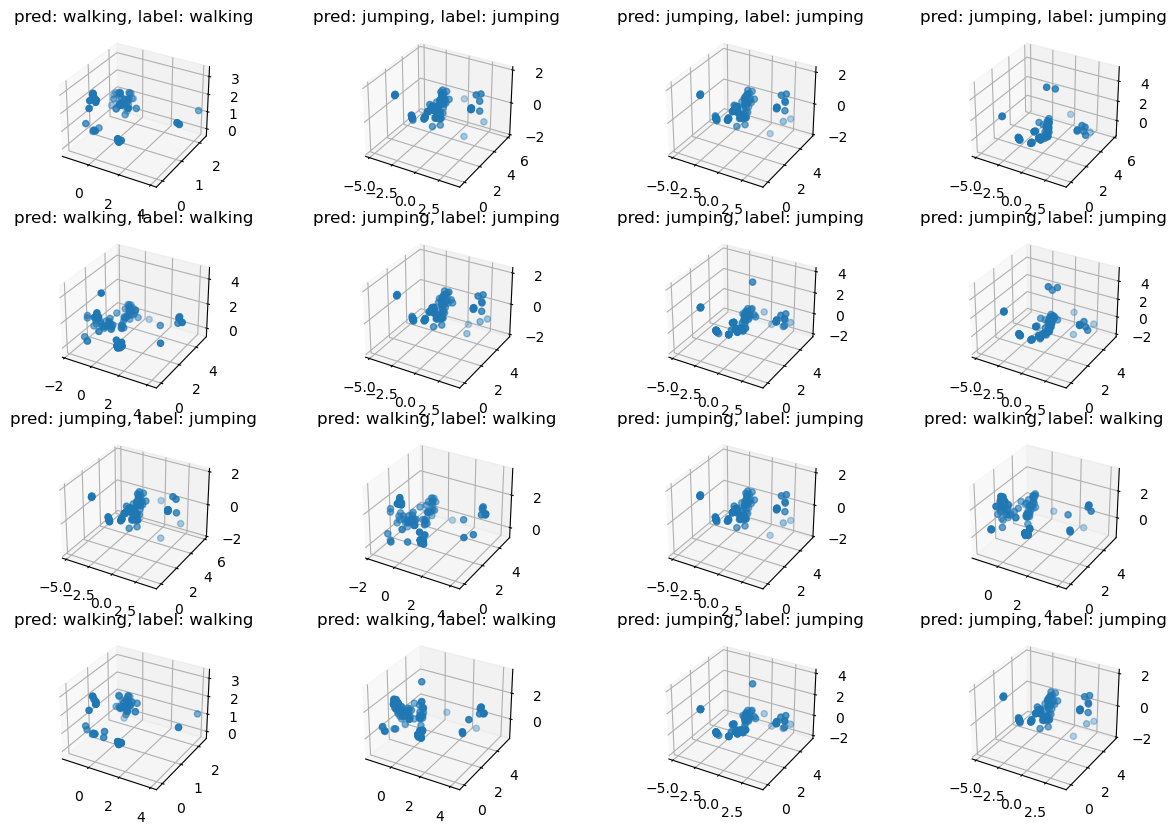

In [19]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [20]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


In [21]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 94.87%


In [22]:
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


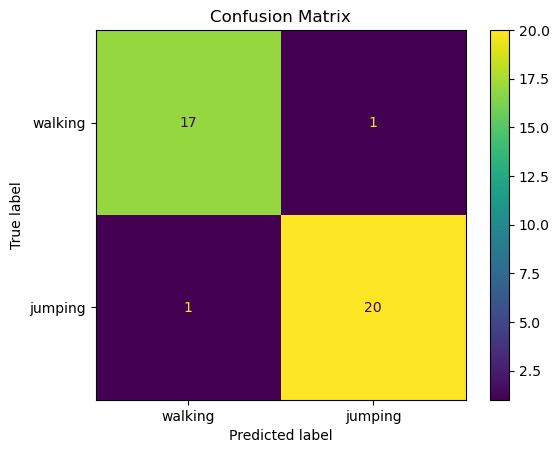

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plotting the confusion matrix
class_names = ['walking', 'jumping']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [72]:
#reload model
reload_model = create_pointnet_model(input_shape, num_points, num_features)
reload_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

NameError: name 'num_points' is not defined

In [50]:
reload_model.load_weights('model/checkpoints/5_09_2024_pointnet_lstm/iter-20.weights.h5')

/Users/katiezhou/mambaforge/envs/py38/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
